# Trainable Distributions

> In this post, we will learn the sampling and log probability of distribution. This is the summary of lecture "Probabilistic Deep Learning with Tensorflow 2" from Coursera.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Deep_Learning, Tensorflow, Probability]
- image: 

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
tfd = tfp.distributions

plt.rcParams['figure.figsize'] = (16, 10)

print("Tensorflow : v" + tf.__version__)
print("Tensorflow probability : v" + tfp.__version__)

Tensorflow : v2.3.1
Tensorflow probability : v0.11.1


## Examples

In [3]:
normal = tfd.Normal(loc=tf.Variable(0., name='loc'), scale=1.)
normal.trainable_variables

(<tf.Variable 'loc:0' shape=() dtype=float32, numpy=0.0>,)

In [4]:
# Negative log likelihood
def nll(X_train):
    return -tf.reduce_mean(normal.log_prob(X_train))

In [5]:
@tf.function
def get_loss_and_grads(X_train):
    with tf.GradientTape() as tape:
        tape.watch(normal.trainable_variables)
        loss = nll(X_train)
        
    grads = tape.gradient(loss, normal.trainable_variables)
    return loss, grads

```python
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)

for _ in range(10):
    loss, grads = get_loss_and_grads(X_sample)
    optimizer.apply_gradients(zip(grads, normal.trainable_variables))
```

## Coding Tutorial

In [6]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score

In [7]:
# Define an exponential distribution
exponential = tfd.Exponential(rate=0.3, name='exp')

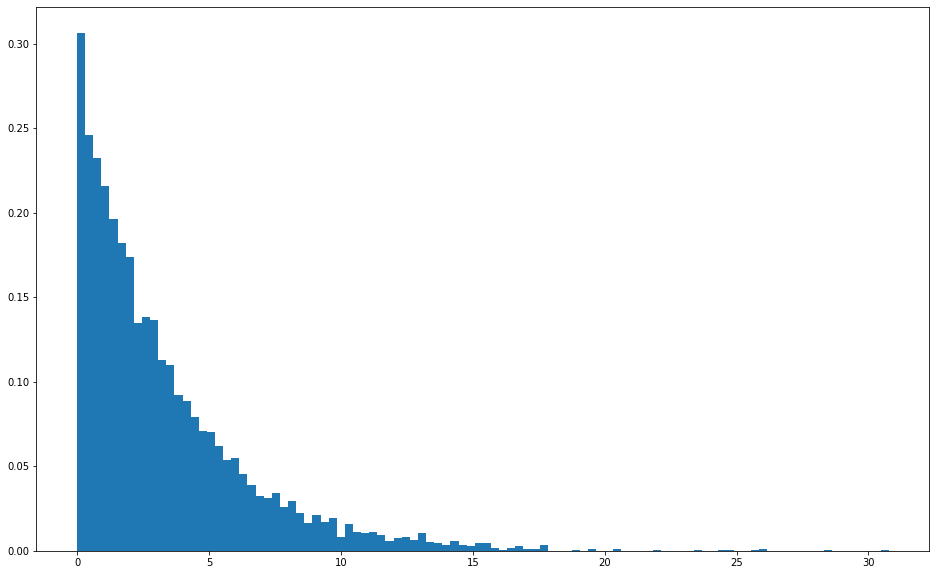

In [8]:
plt.hist(exponential.sample(5000), bins=100, density=True)
plt.show()

In [9]:
# Define an exponential distributino with a trainable rate parameter
exp_train = tfd.Exponential(rate=tf.Variable(1., name='rate'), name='exp_train')
exp_train.trainable_variables

(<tf.Variable 'rate:0' shape=() dtype=float32, numpy=1.0>,)

In [10]:
# Define the negative log likelihood
def nll(X_train, distribution):
    return -tf.reduce_mean(distribution.log_prob(X_train))

In [11]:
# Define a function to compute the loss and gradients
@tf.function
def get_loss_and_grads(X_train, distribution):
    with tf.GradientTape() as tape:
        tape.watch(distribution.trainable_variables)
        loss = nll(X_train, distribution)
    grads = tape.gradient(loss, distribution.trainable_variables)
    return loss, grads

In [12]:
# Optimize
def exponential_dist_optimisation(data, distribution):

    # Keep results for plotting
    train_loss_results = []
    train_rate_results = []
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)

    num_steps = 10

    for i in range(num_steps):
        loss, grads = get_loss_and_grads(data, distribution)
        optimizer.apply_gradients(zip(grads, distribution.trainable_variables))
        
        rate_value = distribution.rate.value()
        train_loss_results.append(loss)
        train_rate_results.append(rate_value)
        
        print("Step {:03d}: Loss: {:.3f}: Rate: {:.3f}".format(i, loss, rate_value))
        
    return train_loss_results, train_rate_results

In [13]:
sampled_data = exponential.sample(5000)
train_loss_results, train_rate_results = exponential_dist_optimisation(data=sampled_data,
                                                                       distribution=exp_train)

Step 000: Loss: 3.372: Rate: 0.881
Step 001: Loss: 3.098: Rate: 0.770
Step 002: Loss: 2.857: Rate: 0.666
Step 003: Loss: 2.652: Rate: 0.572
Step 004: Loss: 2.488: Rate: 0.491
Step 005: Loss: 2.367: Rate: 0.424
Step 006: Loss: 2.288: Rate: 0.374
Step 007: Loss: 2.244: Rate: 0.339
Step 008: Loss: 2.225: Rate: 0.318
Step 009: Loss: 2.218: Rate: 0.307


In [14]:
# Predicted value for the rate parameter
pred_value = exp_train.rate.numpy()
exact_value = exponential.rate.numpy()

print('Exact rate: ', exact_value)
print('Pred rate: ', pred_value)

Exact rate:  0.3
Pred rate:  0.30658525


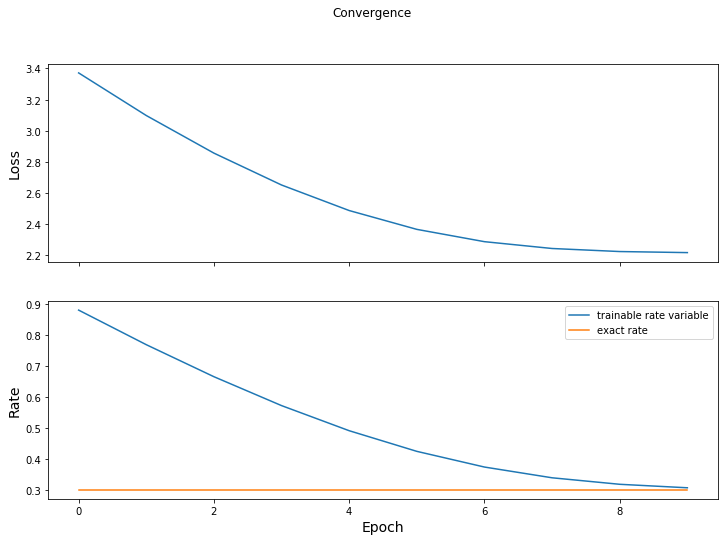

In [15]:
# Plot to see the convergence of the estimated and true parameters

tensor_exact_value = tf.constant(exact_value, shape=[len(train_rate_results)])

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Convergence')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Rate", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_rate_results, label='trainable rate variable')
axes[1].plot(tensor_exact_value, label='exact rate')
axes[1].legend()
plt.show()

In [16]:
# Making a function get_data which:
#   1) Fetches the 20 newsgroup dataset
#   2) Performs a word count on the articles and binarizes the result
#   3) Returns the data as a numpy matrix with the labels

def get_data(categories):

    newsgroups_train_data = fetch_20newsgroups(data_home='20_Newsgroup_Data/',
                                               subset='train', categories=categories)
    newsgroups_test_data = fetch_20newsgroups(data_home='20_Newsgroup_Data/',
                                              subset='test', categories=categories)

    n_documents = len(newsgroups_train_data['data'])
    count_vectorizer = CountVectorizer(input='content', binary=True,max_df=0.25, min_df=1.01/n_documents) 
    train_binary_bag_of_words = count_vectorizer.fit_transform(newsgroups_train_data['data']) 
    test_binary_bag_of_words = count_vectorizer.transform(newsgroups_test_data['data']) 

    return (train_binary_bag_of_words.todense(), newsgroups_train_data['target']),  (test_binary_bag_of_words.todense(), newsgroups_test_data['target'])


In [17]:
# Defining a function to conduct laplace smoothing. This adds a base level of probability for a given feature
# to occur in every class.

def laplace_smoothing(labels, binary_data, n_classes):
    # Compute the parameter estimates (adjusted fraction of documents in class that contain word)
    n_words = binary_data.shape[1]
    alpha = 1 # parameters for Laplace smoothing
    theta = np.zeros([n_classes, n_words]) # stores parameter values - prob. word given class
    for c_k in range(n_classes): # 0, 1, ..., 19
        class_mask = (labels == c_k)
        N = class_mask.sum() # number of articles in class
        theta[c_k, :] = (binary_data[class_mask, :].sum(axis=0) + alpha)/(N + alpha*2)

    return theta

In [18]:
# Now we will do a function that given the feature occurence counts returns a Bernoulli distribution of 
# batch_shape=number of classes and event_shape=number of features.

def make_distributions(probs):
    batch_of_bernoullis = tfd.Bernoulli(probs=probs) # shape (n_classes, n_words)
    dist = tfd.Independent(batch_of_bernoullis, reinterpreted_batch_ndims=1)
    return dist

In [19]:
# Function which computes the prior probability of every class based on frequency of occurence in 
# the dataset

def class_priors(n_classes, labels):
    counts = np.zeros(n_classes)
    for c_k in range(n_classes):
        counts[c_k] = np.sum(np.where(labels==c_k, 1, 0))
    priors = counts / np.sum(counts)
    print('The class priors are {}'.format(priors))
    return priors

In [20]:
# The final function predict_sample which given the distribution, a test sample, and the class priors:
#   1) Computes the class conditional probabilities given the sample
#   2) Forms the joint likelihood
#   3) Normalises the joint likelihood and returns the log prob

def predict_sample(dist, sample, priors):
    cond_probs = dist.log_prob(sample)
    joint_likelihood = tf.add(np.log(priors), cond_probs)
    norm_factor = tf.math.reduce_logsumexp(joint_likelihood, axis=-1, keepdims=True)
    log_prob = joint_likelihood - norm_factor

    return log_prob

In [22]:
# Now we learn the distribution using gradient tape

def make_distribution_withGT(data, labels, nb_classes):

    class_data = []
    train_vars = []
    distributions = []
    for c in range(nb_classes):
        train_vars.append(tf.Variable(initial_value=np.random.uniform(low=0.01, high =0.1, size=data.shape[-1])))
        distributions.append(tfd.Bernoulli(probs=train_vars[c]))
        class_mask = (labels == c)
        class_data.append(data[class_mask, :])

    for c_num in range(0,nb_classes):
        optimizer = tf.keras.optimizers.Adam()
        print('\n%-------------------%')
        print('Class ', c_num)
        print('%-------------------%')

        for i in range(0,100):
            loss, grads = get_loss_and_grads(class_data[c_num], distributions[c_num])
            if i % 10 == 0:
                print('iter: {}, loss: {}'.format(i, loss))
            optimizer.apply_gradients(zip(grads, distributions[c_num].trainable_variables))
            eta = 1e-3
            clipped_probs = tf.clip_by_value(distributions[c_num].trainable_variables,
                                             clip_value_min=eta, clip_value_max=1)
            train_vars[c_num] = tf.squeeze(clipped_probs)

    dist = tfd.Bernoulli(probs=train_vars)
    dist = tfd.Independent(dist,reinterpreted_batch_ndims=1)

    print(dist)

    return dist


In [23]:
# Make the same Naive Bayes classifier we did last tutorial

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

(train_data, train_labels), (test_data, test_labels) = get_data(categories)

smoothed_counts = laplace_smoothing(labels=train_labels, binary_data=train_data, n_classes=len(categories))

priors = class_priors(n_classes=len(categories), labels=train_labels)
tf_dist = make_distributions(smoothed_counts)

The class priors are [0.2359882  0.28711898 0.29154376 0.18534907]


In [24]:
# Now train the distributions with gradient tape

GT_dist = make_distribution_withGT(data=train_data, labels=train_labels, nb_classes=4)


%-------------------%
Class  0
%-------------------%
iter: 0, loss: 0.07849373090947609
iter: 10, loss: 0.06912858998117898
iter: 20, loss: 0.06040006778588954
iter: 30, loss: 0.05232739069716545
iter: 40, loss: 0.044854152013294145
iter: 50, loss: 0.03793270698259863
iter: 60, loss: 0.031517288094255316
iter: 70, loss: 0.025584416537530918
iter: 80, loss: 0.020095664963372152
iter: 90, loss: 0.015000021726957163

%-------------------%
Class  1
%-------------------%
iter: 0, loss: 0.07154726072976736
iter: 10, loss: 0.06222059379279049
iter: 20, loss: 0.05342953748891235
iter: 30, loss: 0.04524157817384579
iter: 40, loss: 0.03764921644104703
iter: 50, loss: 0.03062277603392524
iter: 60, loss: 0.0241275495274357
iter: 70, loss: 0.018140786483862047
iter: 80, loss: 0.012615642720301929
iter: 90, loss: 0.007504351572103787

%-------------------%
Class  2
%-------------------%
iter: 0, loss: 0.07811952107054093
iter: 10, loss: 0.06903955469448385
iter: 20, loss: 0.06069393602787263
iter: 

In [25]:
# Compare the two results

for dist in [GT_dist,tf_dist]:
    probabilities = []
    for sample, label in zip(test_data, test_labels):
        probabilities.append(predict_sample(dist, sample, priors))

    probabilities = np.asarray(probabilities)
    predicted_classes = np.argmax(probabilities, axis =-1)
    print('f1 ', f1_score(test_labels, predicted_classes, average='macro'))

f1  0.8312430355632814
f1  0.7848499112849504
